#### Usaremos los 3 datasets ( DDSM-INbreast_MIAS)

Resolving data files:   0%|          | 0/24576 [00:00<?, ?it/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=227x227 at 0x145C99C50>, 'label': 0}


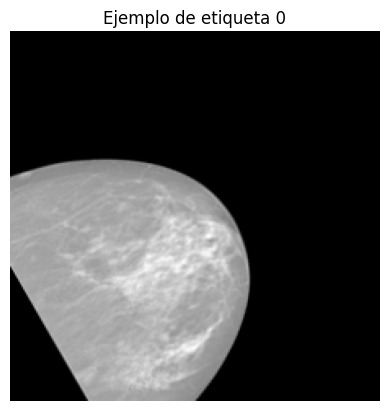

ClassLabel(names=['Benign', 'Malignant'], id=None)
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=227x227 at 0x14544C050>, 'label': 0}


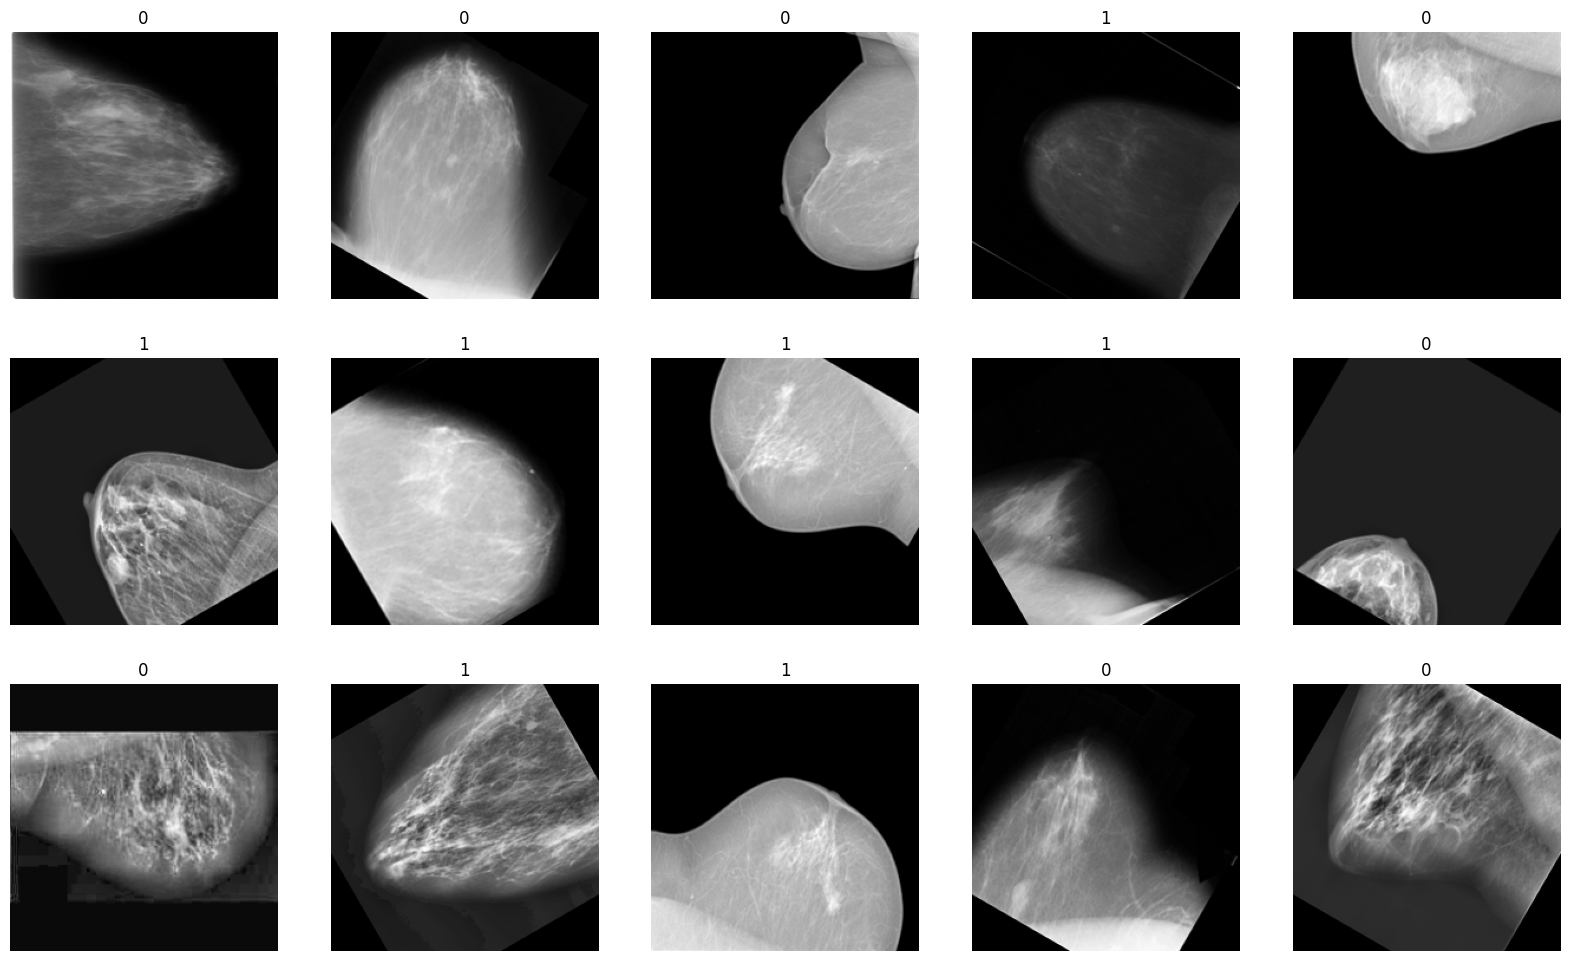

In [1]:
# =============================================================================
# Parte 1: Carga y Preprocesamiento de Datos
# =============================================================================

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from datasets import load_dataset, DatasetDict, ClassLabel
from transformers import AutoImageProcessor

import evaluate  # Biblioteca para métricas de evaluación

# -----------------------------------------------------------------------------
# Carga del conjunto de datos
# -----------------------------------------------------------------------------

# Se carga el conjunto de datos desde la ruta especificada
dataset = load_dataset('/Volumes/m2/Memoria/Code/PMM/BeningMalignant_Masses-Preprocessing/data/original/BeningMalignant_Masses/INbreast+MIAS+DDSM Dataset')

# Inspección del primer ejemplo del conjunto de entrenamiento
print(dataset['train'][0])

# -----------------------------------------------------------------------------
# Visualización de una imagen de ejemplo
# -----------------------------------------------------------------------------

# Obtener la imagen y mostrarla
im = dataset['train'][0]['image']
plt.imshow(im, cmap='gray')
plt.title('Ejemplo de etiqueta 0')
plt.axis('off')
plt.show()

# -----------------------------------------------------------------------------
# Mapeo de etiquetas numéricas a texto
# -----------------------------------------------------------------------------

# Definir el mapeo de etiquetas
label_map = {0: 'Benign', 1: 'Malignant'}

# Actualizar las características del conjunto de datos para incluir nombres de etiquetas
features = dataset['train'].features.copy()
features['label'] = ClassLabel(names=['Benign', 'Malignant'])

# Aplicar el mapeo al conjunto de datos
dataset = dataset.cast(features)

# Verificar las nuevas etiquetas
print(dataset['train'].features['label'])
print(dataset['train'][0])

# Crear diccionarios para mapeo entre etiquetas y IDs
labels = dataset['train'].unique('label')
label2id = {c: idx for idx, c in enumerate(labels)}
id2label = {idx: c for idx, c in enumerate(labels)}

# -----------------------------------------------------------------------------
# Visualización de muestras aleatorias
# -----------------------------------------------------------------------------

def show_samples(ds, rows, cols):
    """
    Muestra una cuadrícula de imágenes y etiquetas aleatorias del conjunto de datos.

    Args:
        ds (Dataset): Conjunto de datos de Hugging Face.
        rows (int): Número de filas en la cuadrícula.
        cols (int): Número de columnas en la cuadrícula.
    """
    samples = ds.shuffle().select(np.arange(rows * cols))
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

# Mostrar muestras del conjunto de entrenamiento
show_samples(dataset['train'], rows=3, cols=5)

# -----------------------------------------------------------------------------
# División del conjunto de datos en entrenamiento, validación y prueba
# -----------------------------------------------------------------------------

# Dividir el conjunto de entrenamiento en entrenamiento y prueba intermedia
split_dataset = dataset['train'].train_test_split(test_size=0.2)

# Dividir el conjunto de prueba intermedia en validación y prueba
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5)

# Crear el conjunto de datos final con entrenamiento, validación y prueba
final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

# -----------------------------------------------------------------------------
# Preprocesamiento de las imágenes
# -----------------------------------------------------------------------------

# Cargar el procesador de imágenes preentrenado
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224', use_fast=True)

def transforms(batch):
    """
    Aplica transformaciones a un batch de datos.

    Args:
        batch (dict): Batch de datos.

    Returns:
        dict: Batch transformado con 'pixel_values' y 'labels'.
    """
    # Convertir imágenes a RGB
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    # Procesar imágenes
    inputs = processor(batch['image'], return_tensors='pt')
    # Mapear etiquetas de texto a IDs numéricos
    inputs['labels'] = [label2id[y] for y in batch['label']]
    return inputs

# Aplicar las transformaciones al conjunto de datos
processed_dataset = final_dataset.with_transform(transforms)

# -----------------------------------------------------------------------------
# Definición de la función de colación de datos
# -----------------------------------------------------------------------------

def collate_fn(batch):
    """
    Función personalizada para colacionar los datos en batches.

    Args:
        batch (list): Lista de ejemplos.

    Returns:
        dict: Batch colacionado con 'pixel_values' y 'labels' como tensores.
    """
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# -----------------------------------------------------------------------------
# Definición de la métrica de evaluación
# -----------------------------------------------------------------------------

# Cargar la métrica de precisión
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_preds):
    """
    Calcula las métricas de evaluación.

    Args:
        eval_preds (tuple): Tupla que contiene logits y etiquetas verdaderas.

    Returns:
        dict: Diccionario con la precisión calculada.
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score


In [2]:
# =============================================================================
# Parte 2: Configuración y Entrenamiento del Modelo con Correcciones
# =============================================================================

from transformers import ViTForImageClassification, Trainer, TrainingArguments
from transformers import TrainerCallback
from torch.utils.tensorboard import SummaryWriter

# -----------------------------------------------------------------------------
# Carga del modelo preentrenado
# -----------------------------------------------------------------------------

# Cargar el modelo ViT preentrenado para clasificación de imágenes
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(labels),
    ignore_mismatched_sizes=True
)

# -----------------------------------------------------------------------------
# Congelar todas las capas excepto el clasificador
# -----------------------------------------------------------------------------

for name, p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

# Mostrar el número total de parámetros y los entrenables
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total de parámetros: {num_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

# -----------------------------------------------------------------------------
# Configuración de los argumentos de entrenamiento con TensorBoard
# -----------------------------------------------------------------------------

training_args = TrainingArguments(
    output_dir="./VT_P4",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',  # Reportar a TensorBoard
    logging_dir='./VT_P4/runs',  # Directorio de logs para TensorBoard
    load_best_model_at_end=True,
)

# -----------------------------------------------------------------------------
# Definición del Callback Personalizado para TensorBoard 
# -----------------------------------------------------------------------------

class CustomTensorBoardCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.writer = None

    def on_train_begin(self, args, state, control, **kwargs):
        if self.writer is None:
            # Inicializar el SummaryWriter de TensorBoard
            self.writer = SummaryWriter(log_dir=args.logging_dir)
            print(f"TensorBoard logs guardados en {args.logging_dir}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Este método se llama cada vez que el trainer registra logs.
        """
        if self.writer and logs is not None:
            for k, v in logs.items():
                if isinstance(v, (int, float)):
                    self.writer.add_scalar(k, v, state.global_step)

    def on_epoch_end(self, args, state, control, **kwargs):
        """
        Registrar imágenes y predicciones al final de cada época.
        """
        # Asegurarse de que state.epoch no es None y convertirlo a entero
        if state.epoch is not None:
            epoch_seed = int(state.epoch)
        else:
            epoch_seed = 0  # Valor por defecto si state.epoch es None

        # Seleccionar muestras aleatorias del conjunto de validación
        samples = final_dataset['validation'].shuffle(seed=epoch_seed).select(range(4))
        processed_samples = samples.with_transform(transforms)
        predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)

        for idx in range(len(samples)):
            img = samples[idx]['image']
            img = img.convert('RGB')
            img_tensor = processor(images=img, return_tensors="pt")['pixel_values'][0]
            # Reescalar la imagen para visualización
            img_np = img_tensor.permute(1, 2, 0).numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

            # Obtener la etiqueta real y la predicción
            label_real = samples[idx]['label']
            label_pred = id2label[predictions[idx]]

            # Añadir imagen al TensorBoard
            self.writer.add_image(f'Epoch_{epoch_seed}/Image_{idx}', img_np, dataformats='HWC')
            # Añadir texto con la etiqueta real y predicha
            self.writer.add_text(
                f'Epoch_{epoch_seed}/Prediction_{idx}',
                f'Real: {label_real}, Predicción: {label_pred}',
                state.global_step
            )

    def on_train_end(self, args, state, control, **kwargs):
        if self.writer:
            self.writer.close()
            self.writer = None

# -----------------------------------------------------------------------------
# Inicialización del entrenador con el Callback de TensorBoard
# -----------------------------------------------------------------------------

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor,
    callbacks=[CustomTensorBoardCallback()],  # Añadir el callback personalizado
)

# -----------------------------------------------------------------------------
# Verificación de la disponibilidad de MPS (para dispositivos Apple)
# -----------------------------------------------------------------------------

# Verificar si MPS está disponible (para acelerar en GPUs de Apple)
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS no está disponible porque PyTorch no fue compilado con soporte para MPS.")
    else:
        print("MPS no está disponible debido a la versión de macOS o falta de hardware compatible.")
else:
    mps_device = torch.device("mps")
    print("Usando dispositivo MPS para el entrenamiento.")

# -----------------------------------------------------------------------------
# Entrenamiento del modelo
# -----------------------------------------------------------------------------

trainer.train()

# Guardar el modelo entrenado
trainer.save_model()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Volumes/m2/Memoria/Code/PMM/venv2/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Total de parámetros: 85,800,194
Parámetros entrenables: 1,538
Usando dispositivo MPS para el entrenamiento.
TensorBoard logs guardados en ./VT_P4/runs


Epoch,Training Loss,Validation Loss,Accuracy
1,0.483200,0.462184,0.792514
2,0.424500,0.405841,0.826282
3,0.392700,0.383892,0.829943
4,0.394600,0.367222,0.842555
5,0.366700,0.357183,0.851505
6,0.350000,0.355318,0.849471
7,0.348200,0.345069,0.854760
8,0.356500,0.341264,0.860456
9,0.343700,0.338536,0.857201
10,0.351800,0.337928,0.859235


{'eval_loss': 0.35853147506713867, 'eval_accuracy': 0.8576078112286412, 'eval_runtime': 86.0906, 'eval_samples_per_second': 28.551, 'eval_steps_per_second': 3.578, 'epoch': 10.0}


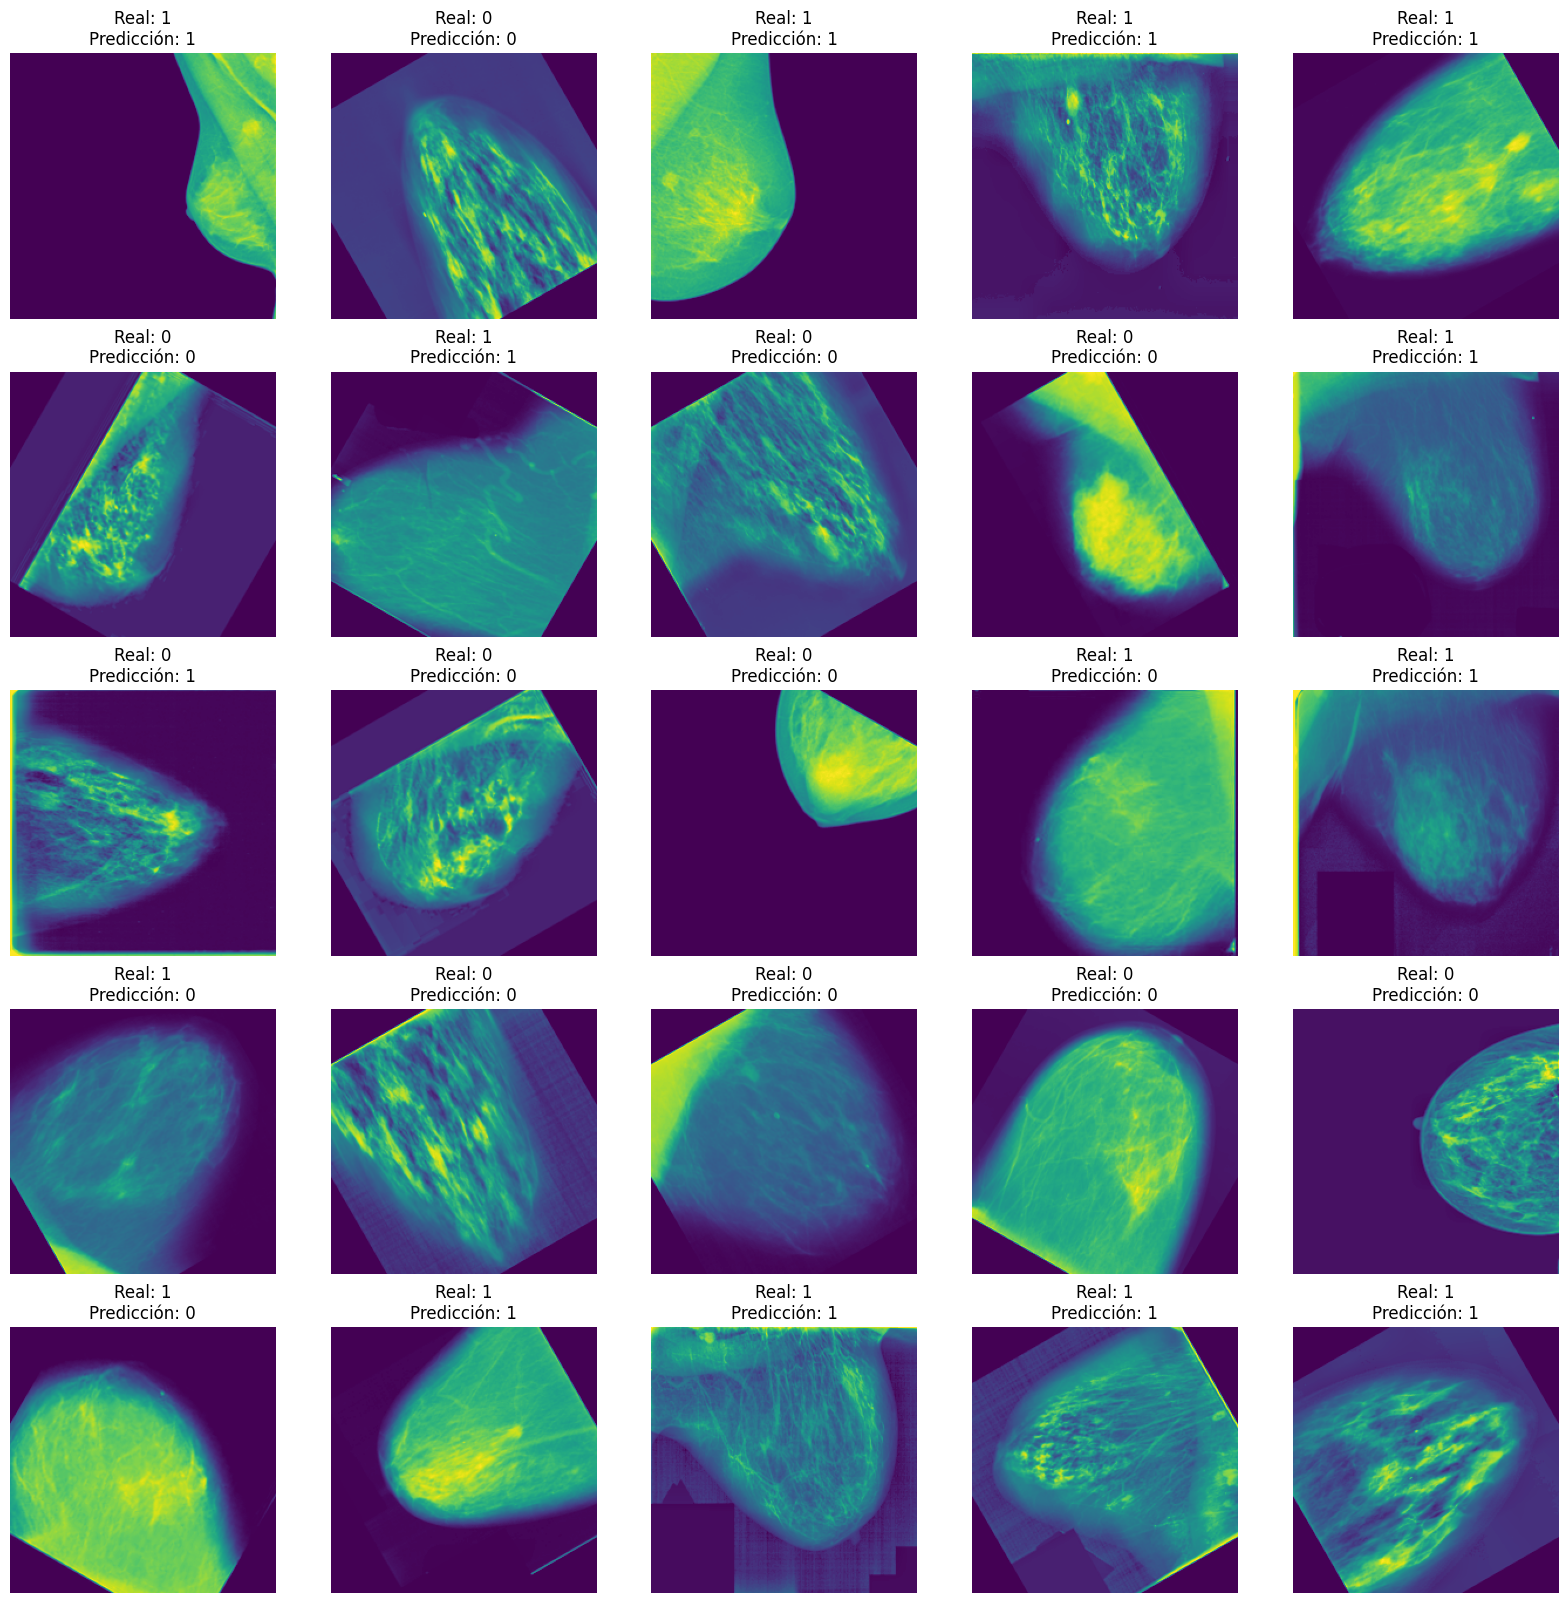

In [3]:
# =============================================================================
# Parte 3: Evaluación y Visualización de Resultados
# =============================================================================

# -----------------------------------------------------------------------------
# Evaluación del modelo en el conjunto de prueba
# -----------------------------------------------------------------------------

evaluation_results = trainer.evaluate(processed_dataset['test'])
print(evaluation_results)

# -----------------------------------------------------------------------------
# Función para mostrar predicciones
# -----------------------------------------------------------------------------

def show_predictions(rows, cols):
    """
    Muestra una cuadrícula de imágenes con sus etiquetas reales y predicciones.

    Args:
        rows (int): Número de filas en la cuadrícula.
        cols (int): Número de columnas en la cuadrícula.
    """
    samples = final_dataset['test'].shuffle().select(np.arange(rows * cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]['image']
        prediction = predictions[i]
        label_real = samples[i]['label']
        label_pred = id2label[prediction]
        label = f"Real: {label_real}\nPredicción: {label_pred}"
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Mostrar predicciones en el conjunto de prueba
show_predictions(rows=5, cols=5)


### Resumen del proceso de entrenamiento y resultados

#### Configuración del modelo

1. **Modelo utilizado**: ViT (Vision Transformer) preentrenado para clasificación de imágenes.
   - Se utilizó el modelo `vit-base-patch16-224` de Google.
   - El modelo fue configurado para manejar el número de clases correspondiente a la tarea.
   - Se ignoraron tamaños de parámetros incompatibles durante la carga del modelo.

2. **Congelación de capas**: 
   - Todas las capas del modelo fueron congeladas excepto la capa del clasificador, lo que significa que solo los parámetros del clasificador se entrenaron.
   - Se mostraron los **parámetros totales** y los **parámetros entrenables**, resultando en **85,800,194 parámetros totales** y **1,538 parámetros entrenables**.

#### Configuración de los argumentos de entrenamiento

- **Batch size**: 16.
- **Número de épocas**: 10.
- **Learning rate**: 3e-4.
- **Estrategia de evaluación y guardado**: Se evaluó y guardó el modelo al final de cada época.
- **Dirección de salida**: Los resultados y logs se guardaron en `./VT_P4/runs`.

#### TensorBoard

- Se habilitó la visualización de logs con **TensorBoard**, generando imágenes, métricas y predicciones de validación al final de cada época.
- Los logs se guardaron en la carpeta `./VT_P4/runs`.

#### Resultados del entrenamiento

- **Dispositivo de entrenamiento**: Se utilizó un dispositivo **MPS** (Apple Silicon GPU) para acelerar el entrenamiento.
- **Número de épocas**: 10.
- **Pérdida de entrenamiento** y **pérdida de validación** disminuyeron progresivamente, mostrando una mejora significativa en cada época.
- **Precisión**:
  - Comenzó en **79.25%** en la primera época y alcanzó **85.92%** en la última.

| Época | Pérdida de Entrenamiento | Pérdida de Validación | Precisión |
|-------|---------------------------|-----------------------|-----------|
| 1     | 0.483200                  | 0.462184              | 79.25%    |
| 2     | 0.424500                  | 0.405841              | 82.63%    |
| 3     | 0.392700                  | 0.383892              | 82.99%    |
| 4     | 0.394600                  | 0.367222              | 84.26%    |
| 5     | 0.366700                  | 0.357183              | 85.15%    |
| 6     | 0.350000                  | 0.355318              | 84.95%    |
| 7     | 0.348200                  | 0.345069              | 85.48%    |
| 8     | 0.356500                  | 0.341364              | 86.05%    |
| 9     | 0.343700                  | 0.338536              | 85.72%    |
| 10    | 0.351800                  | 0.337328              | 85.92%    |

#### Conclusión

El modelo **ViT** preentrenado, con la capa del clasificador finamente ajustada, mostró una mejora continua en la pérdida y precisión a lo largo de 10 épocas, alcanzando un **85.92% de precisión** en las últimas épocas.

#### Explicación de los resultados

Este entrenamiento se realizó utilizando más datasets, lo que resultó en una mejor generalización del modelo. La mayor diversidad en los datos permitió al modelo ajustar mejor los patrones y características relevantes para la clasificación de imágenes médicas. Aunque la precisión es menor que en otros entrenamientos previos, el uso de varios conjuntos de datos ayuda a reducir el sobreajuste y mejora el rendimiento en tareas más complejas. Se podrían obtener mejores resultados con una mayor cantidad de épocas o ajustes adicionales en los hiperparámetros.
